In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=33)

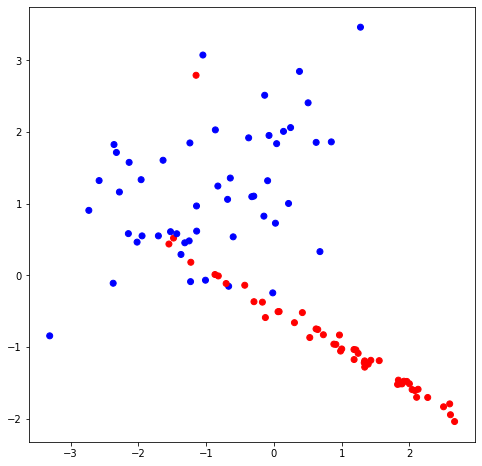

In [3]:
#визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    

    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

### 1 дерево

In [20]:
n_trees_1 = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees_1)

In [21]:
# Получим ответы для обучающей выборки 
train_answers_1 = tree_vote(my_forest_1, train_data)

In [22]:
# И получим ответы для тестовой выборки
test_answers_1 = tree_vote(my_forest_1, test_data)

In [23]:
# Точность на обучающей выборке
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
print(f'Точность случайного леса из {n_trees_1} деревьев на обучающей выборке: {train_accuracy_1:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 92.857


In [24]:
# Точность на тестовой выборке
test_accuracy_1 = accuracy_metric(test_labels, test_answers_1)
print(f'Точность случайного леса из {n_trees_1} деревьев на тестовой выборке: {test_accuracy_1:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 80.000


Text(0.5, 1.0, 'Test accuracy=80.00')

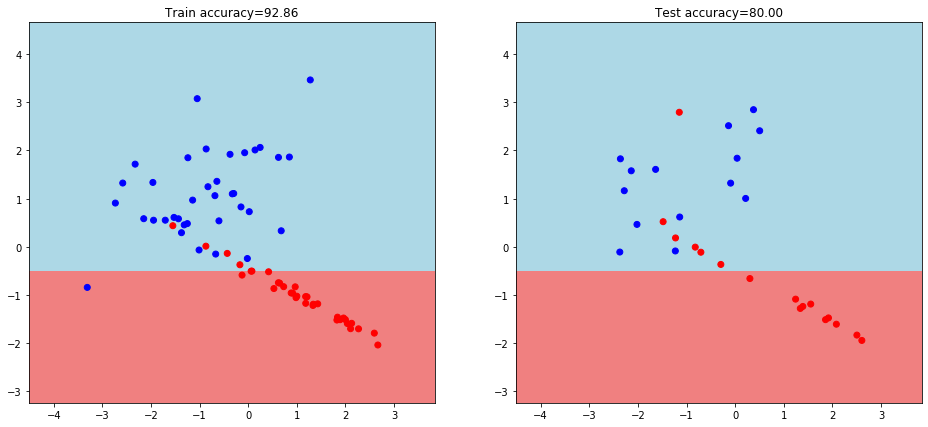

In [25]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_1:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_1:.2f}')

### 3 дерева

In [26]:
n_trees_3 = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees_3)

In [27]:
# Получим ответы для обучающей выборки 
train_answers_3 = tree_vote(my_forest_3, train_data)

In [28]:
# И получим ответы для тестовой выборки
test_answers_3 = tree_vote(my_forest_3, test_data)

In [29]:
# Точность на обучающей выборке
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
print(f'Точность случайного леса из {n_trees_3} деревьев на обучающей выборке: {train_accuracy_3:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 92.857


In [30]:
# Точность на тестовой выборке
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)
print(f'Точность случайного леса из {n_trees_3} деревьев на тестовой выборке: {test_accuracy_3:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 80.000


Text(0.5, 1.0, 'Test accuracy=80.00')

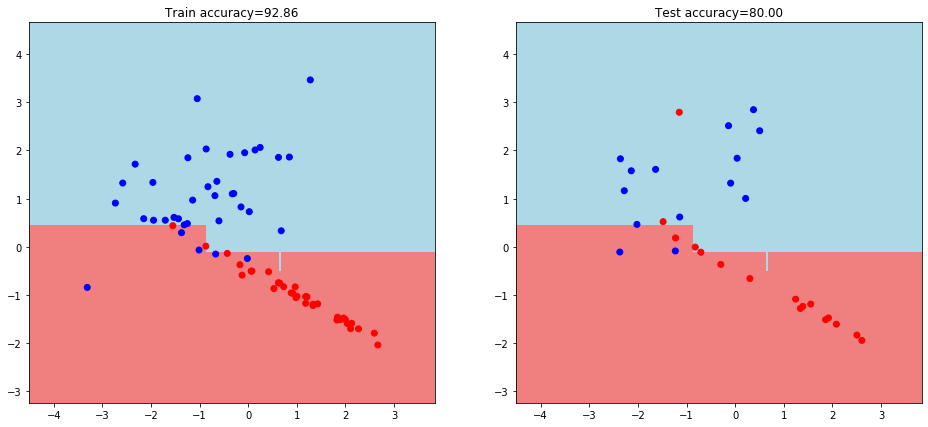

In [31]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_3:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_3:.2f}')

### 10 деревьев

In [32]:
n_trees_10 = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees_10)

In [33]:
# Получим ответы для обучающей выборки 
train_answers_10 = tree_vote(my_forest_10, train_data)

In [34]:
# И получим ответы для тестовой выборки
test_answers_10 = tree_vote(my_forest_10, test_data)

In [35]:
# Точность на обучающей выборке
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
print(f'Точность случайного леса из {n_trees_10} деревьев на обучающей выборке: {train_accuracy_10:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 95.714


In [36]:
# Точность на тестовой выборке
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)
print(f'Точность случайного леса из {n_trees_10} деревьев на тестовой выборке: {test_accuracy_10:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 83.333


Text(0.5, 1.0, 'Test accuracy=83.33')

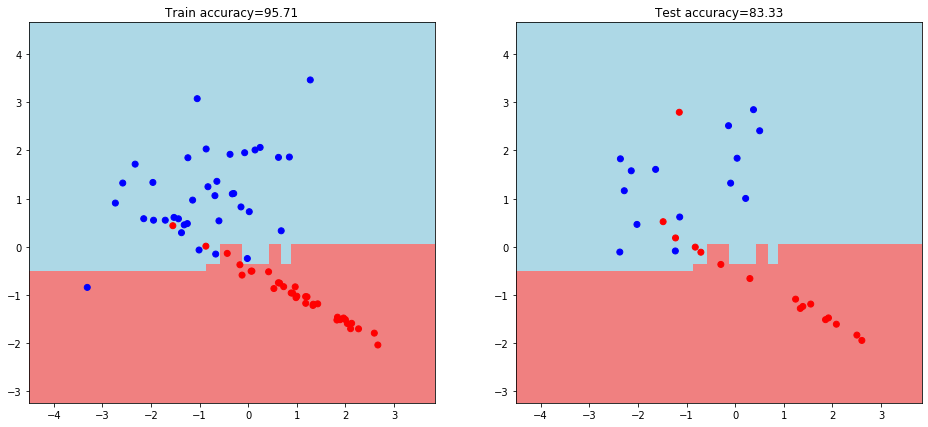

In [37]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_10:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_10:.2f}')

### 50 деревьев

In [38]:
n_trees_50 = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees_50)

In [39]:
# Получим ответы для обучающей выборки 
train_answers_50 = tree_vote(my_forest_50, train_data)

In [40]:
# И получим ответы для тестовой выборки
test_answers_50 = tree_vote(my_forest_50, test_data)

In [41]:
# Точность на обучающей выборке
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)
print(f'Точность случайного леса из {n_trees_50} деревьев на обучающей выборке: {train_accuracy_50:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 94.286


In [42]:
# Точность на тестовой выборке
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)
print(f'Точность случайного леса из {n_trees_50} деревьев на тестовой выборке: {test_accuracy_50:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 80.000


Text(0.5, 1.0, 'Test accuracy=80.00')

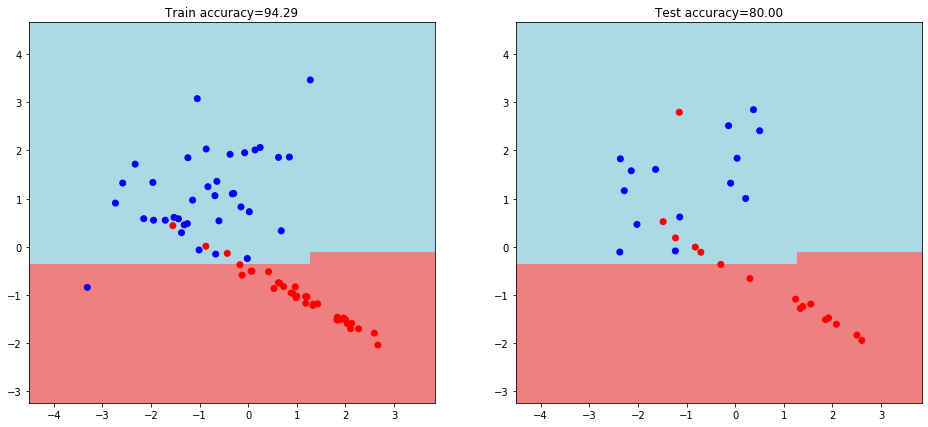

In [43]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_50:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_50:.2f}')

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

При построении случайный лесов с количеством деревьев 1 или 3, гиперплоскости очень простые, наблюдается явное недообучение. При построении случайного леса из 10 деревьев, гиперплоскости становятся гораздо сложнее, видим явный скачек качества. А вот при увеличении количества деревьев до 50 наблюдаем резкое снижение качества на test, что говорит о переобучении.

### 3*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [44]:
# функция формирования предсказания по выборке на одном дереве

def predict_OOB(data, tree):    
    classes = []
    for obj in data:
        
        prediction = classify_object_OOB(obj, tree)
        classes.append(prediction)
    return classes

In [45]:
# Функция классификации отдельного объекта

def classify_object_OOB(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        if obj not in node.data:
            answer = node.prediction
            return answer
        else:
            return None

    if obj[node.index] <= node.t:
        return classify_object_OOB(obj, node.true_branch)
    else:
        return classify_object_OOB(obj, node.false_branch)

In [46]:
# предсказание голосованием деревьев

def tree_vote_OOB(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict_OOB(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [47]:
n_trees_3 = 3
my_forest_3_OOB = random_forest(classification_data, classification_labels, n_trees_3)

In [48]:
# Получим ответы для выборки 
answers_3 = tree_vote(my_forest_3_OOB, classification_data)

In [49]:
# Получим ответы для выборки 
OOB_answers_3 = tree_vote_OOB(my_forest_3_OOB, classification_data)

In [50]:
# Точность на обучающей выборке
train_accuracy_3 = accuracy_metric(classification_labels, answers_3)
print(f'Точность случайного леса из {n_trees_3} деревьев на обучающей выборке: {train_accuracy_3:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 93.000


In [51]:
# Точность на обучающей выборке
train_accuracy_3_OOB = accuracy_metric(classification_labels, OOB_answers_3)
print(f'OOB error случайного леса из {n_trees_3} деревьев на обучающей выборке: {train_accuracy_3_OOB:.3f}')

OOB error случайного леса из 10 деревьев на обучающей выборке: 18.000


### 4*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [52]:
import math

In [53]:
# Расчет энтропии Шенона

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    sum_ = 0
    for label in classes:
        p = classes[label] / len(labels)
        sum_ += p * math.log(p, 2.0)
        
    return -sum_

In [54]:
# Расчет качества

def quality_entropy(left_labels, right_labels, current_entropy):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    

    
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

In [55]:
# Нахождение наилучшего разбиения

def find_best_split_entropy(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = calc_entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_entropy(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [56]:
# Построение дерева с помощью рекурсивной функции

def build_tree_entropy(data, labels):

    quality, t, index = find_best_split_entropy(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_entropy(true_data, true_labels)
    false_branch = build_tree_entropy(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [57]:
def random_forest_entropy(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree_entropy(b_data, b_labels))
        
    return forest

In [58]:
n_trees_10 = 10
my_forest_10_entropy = random_forest_entropy(train_data, train_labels, n_trees_10)

In [59]:
# Получим ответы для обучающей выборки 
train_answers_10_entropy = tree_vote(my_forest_10, train_data)

In [60]:
# И получим ответы для тестовой выборки
test_answers_10_entropy = tree_vote(my_forest_10, test_data)

In [61]:
# Точность на обучающей выборке
train_accuracy_10_entropy = accuracy_metric(train_labels, train_answers_10_entropy)
print(f'Точность случайного леса из {n_trees_10} деревьев на обучающей выборке: {train_accuracy_10_entropy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 95.714


In [62]:
# Точность на тестовой выборке
test_accuracy_10_entropy = accuracy_metric(test_labels, test_answers_10_entropy)
print(f'Точность случайного леса из {n_trees_10} деревьев на тестовой выборке: {test_accuracy_10_entropy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 83.333


Text(0.5, 1.0, 'Test accuracy=83.33')

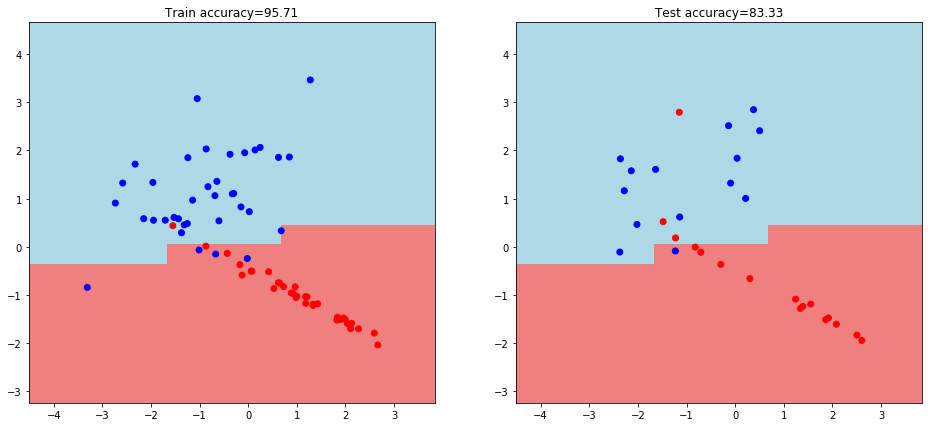

In [63]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10_entropy, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy_10_entropy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy_10_entropy:.2f}')